# Ethereum Price Prediction

Our goal of this notebook is to predict whether the current signal is **sell or buy** depending on the short term and long term price, using classification based models.

## The Problem

- The problem of predicting a buy or sell signal for a trading strategy is defined in the classification framework, where the predicted variable has a value of 1 for buy and 0 for sell.
- The buy or sell signal are decided on the basis on the comparison of short term and long term prices.
- we get the data in terms of average daily volume traded—Bitstamp (https://www.bitstamp.com). Data can be found at: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset

## Loading the python packages

In [1]:
# Load packages

import numpy as np
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier


#Libraries for Deep Learning Models

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

## Loading the Dataset

In [2]:
# loading dataset
dataset = pd.read_csv('ETH.csv')

In [3]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Exploring the Dataset

In [4]:
# shape
dataset.shape

(1048575, 6)

In [5]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,date,open,high,low,close,volume
1048570,18/02/2018 04:13,954.12,955.92,954.12,955.42,4.158083
1048571,18/02/2018 04:12,957.87,957.87,953.78,954.12,27.260190
1048572,18/02/2018 04:11,955.93,957.87,955.93,957.87,10.583997
1048573,18/02/2018 04:10,955.50,955.93,955.50,955.93,0.105639
1048574,18/02/2018 04:09,955.56,955.67,955.50,955.50,3.485150


In [7]:
# describe data
dataset.describe()

,open,high,low,close,volume
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2.766138e+02,2.767168e+02,2.765052e+02,2.766132e+02,1.658664e+01
std,1.853888e+02,1.854661e+02,1.853034e+02,1.853876e+02,1.034367e+02
min,8.083000e+01,8.083000e+01,8.083000e+01,8.083000e+01,0.000000e+00
25%,1.528000e+02,1.528800e+02,1.527600e+02,1.528000e+02,0.000000e+00
50%,2.007000e+02,2.007500e+02,2.006900e+02,2.007000e+02,0.000000e+00
75%,3.078000e+02,3.079500e+02,3.076300e+02,3.078000e+02,3.713994e+00
max,9.580500e+02,9.590000e+02,9.580500e+02,9.580500e+02,1.926126e+04


## Preparing the Dataset

### Cleaning the Data

In [8]:
# Checking if there are any null values 
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [9]:
dataset=dataset.drop(columns=['date'])

In [10]:
dataset.tail()

,open,high,low,close,volume
1048570,954.12,955.92,954.12,955.42,4.158083
1048571,957.87,957.87,953.78,954.12,27.260190
1048572,955.93,957.87,955.93,957.87,10.583997
1048573,955.50,955.93,955.50,955.93,0.105639
1048574,955.56,955.67,955.50,955.50,3.485150


### Preparing the Data for Classification

We attach a label to each movement: 
- **1** if the signal is that short term price will go up as compared to the long term. 
- **0** if the signal is that short term price will go down as compared to the long term.

In [11]:
# Create short simple moving average over a short 10-day-window
dataset['short_mvg'] = dataset['close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over a long 60-day-window
dataset['long_mvg'] = dataset['close'].rolling(window=60, min_periods=1, center=False).mean()

# Create the signals
dataset['signal'] = np.where(dataset['short_mvg'] > dataset['long_mvg'], 1.0, 0.0)

In [12]:
dataset.tail(5)

,open,high,low,close,volume,short_mvg,long_mvg,signal
1048570,954.12,955.92,954.12,955.42,4.158083,954.124,954.681333,0.0
1048571,957.87,957.87,953.78,954.12,27.260190,953.938,954.760833,0.0
1048572,955.93,957.87,955.93,957.87,10.583997,954.413,954.875333,0.0
1048573,955.50,955.93,955.50,955.93,0.105639,954.694,954.927000,0.0
1048574,955.56,955.67,955.50,955.50,3.485150,954.932,954.960833,0.0


### Feature Extraction

We start by the constructing of the dataset that contains the predictors which will be used to make the predictions, and the output variable too.

The current Data of the Ethereum consists of open, high, low, close and volume. by using this data we can calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of noise on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [13]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['close'], 10)
dataset['ROC30'] = ROC(dataset['close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['close'], 10)
dataset['MOM30'] = MOM(dataset['close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['close'], 10)
dataset['RSI30'] = RSI(dataset['close'], 30)
dataset['RSI200'] = RSI(dataset['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['close'], dataset['low'], dataset['high'], 10)
dataset['%D10'] = STOD(dataset['close'], dataset['low'], dataset['high'], 10)
dataset['%K30'] = STOK(dataset['close'], dataset['low'], dataset['high'], 30)
dataset['%D30'] = STOD(dataset['close'], dataset['low'], dataset['high'], 30)
dataset['%K200'] = STOK(dataset['close'], dataset['low'], dataset['high'], 200)
dataset['%D200'] = STOD(dataset['close'], dataset['low'], dataset['high'], 200)

In [40]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

In [15]:
dataset.tail()

,open,high,low,close,volume,short_mvg,long_mvg,signal,EMA10,EMA30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1048570,954.12,955.92,954.12,955.42,4.158083,954.124,954.681333,0.0,954.551455,954.589385,...,54.966008,85.347044,53.727825,72.459893,61.051693,93.063584,90.821510,954.124,955.016000,939.5506
1048571,957.87,957.87,953.78,954.12,27.260190,953.938,954.760833,0.0,954.473009,954.559102,...,54.570589,35.008666,52.757975,52.350699,60.052728,89.647924,90.803994,953.938,955.070000,939.6742
1048572,955.93,957.87,955.93,957.87,10.583997,954.413,954.875333,0.0,955.090643,954.772709,...,55.498702,100.000000,73.451903,100.000000,74.936864,99.500788,94.070765,954.413,955.255333,939.8123
1048573,955.50,955.93,955.50,955.93,0.105639,954.694,954.927000,0.0,955.243254,954.847373,...,54.915384,66.377816,67.128827,75.349428,75.900042,94.403573,94.517429,954.694,955.289000,939.9407
1048574,955.56,955.67,955.50,955.50,3.485150,954.932,954.960833,0.0,955.289935,954.889478,...,54.787108,55.198488,73.858768,58.925477,78.091635,93.273778,95.726047,954.932,955.307667,940.0657


In [16]:
#excluding columns that are not needed for our prediction.
dataset=dataset.drop(['high','low','open','short_mvg','long_mvg'], axis=1)

In [17]:
dataset = dataset.dropna(axis=0)

In [18]:
dataset.tail()

,close,volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1048570,955.42,4.158083,0.0,954.551455,954.589385,942.883732,-0.058579,0.306562,-1.08,1.18,...,54.966008,85.347044,53.727825,72.459893,61.051693,93.063584,90.821510,954.124,955.016000,939.5506
1048571,954.12,27.260190,0.0,954.473009,954.559102,942.995536,0.104919,0.190064,-1.86,1.62,...,54.570589,35.008666,52.757975,52.350699,60.052728,89.647924,90.803994,953.938,955.070000,939.6742
1048572,957.87,10.583997,0.0,955.090643,954.772709,943.143540,0.498363,0.308926,4.75,5.56,...,55.498702,100.000000,73.451903,100.000000,74.936864,99.500788,94.070765,954.413,955.255333,939.8123
1048573,955.93,0.105639,0.0,955.243254,954.847373,943.270769,0.294821,0.103671,2.81,1.01,...,54.915384,66.377816,67.128827,75.349428,75.900042,94.403573,94.517429,954.694,955.289000,939.9407
1048574,955.50,3.485150,0.0,955.289935,954.889478,943.392453,0.249706,0.007327,2.38,0.56,...,54.787108,55.198488,73.858768,58.925477,78.091635,93.273778,95.726047,954.932,955.307667,940.0657


### Data Visualization

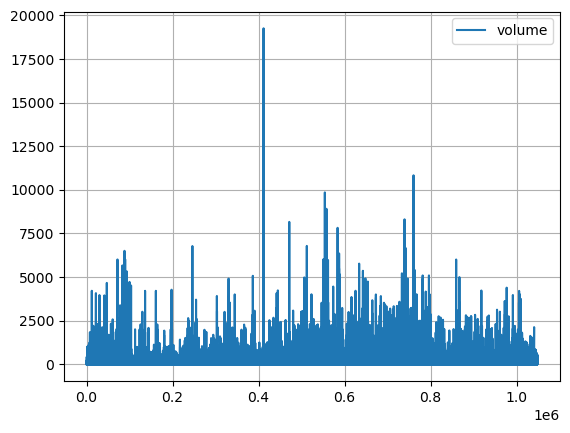

In [19]:
dataset[['volume']].plot(grid=True)
plt.show()

#### Histograms

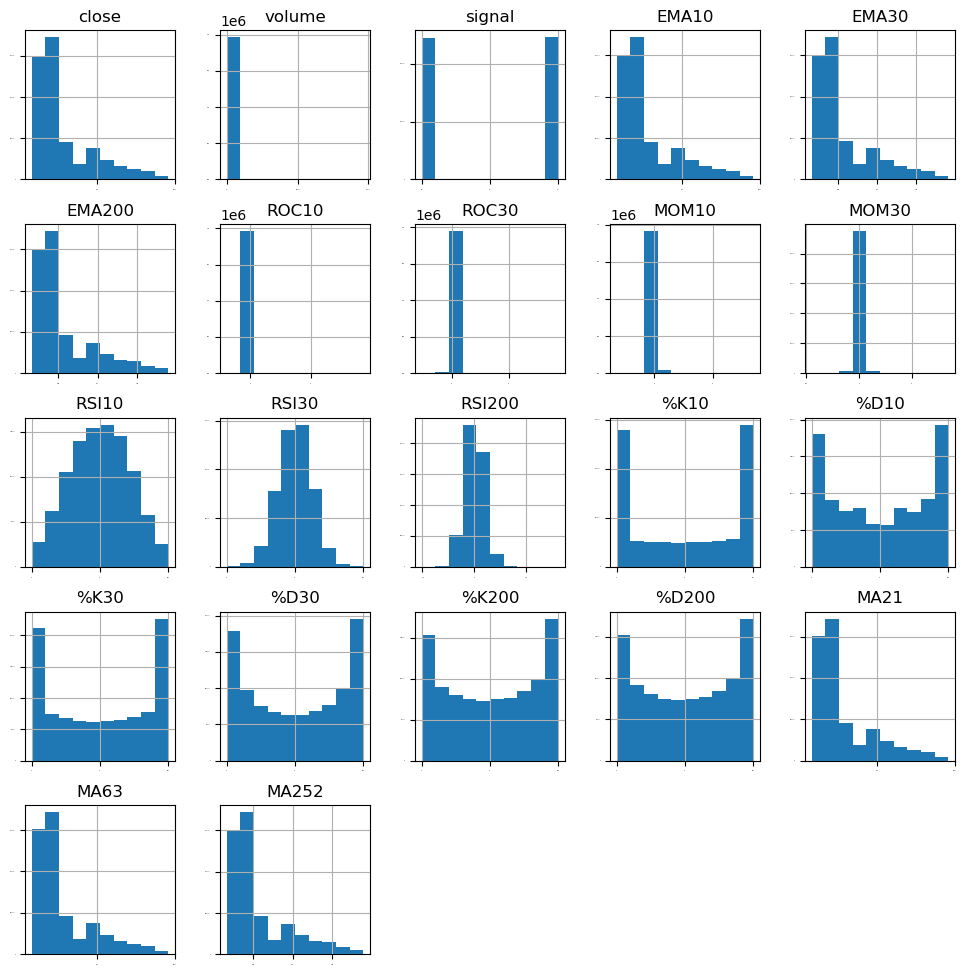

In [20]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

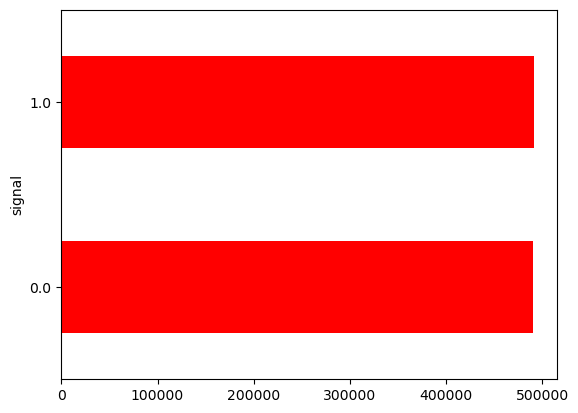

In [21]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

- The predicted variable is around 50% out of total data-size, meaning that number of the buy signals were nearly as the same as the number of sell signals. 

<AxesSubplot: title={'center': 'Correlation Matrix'}>

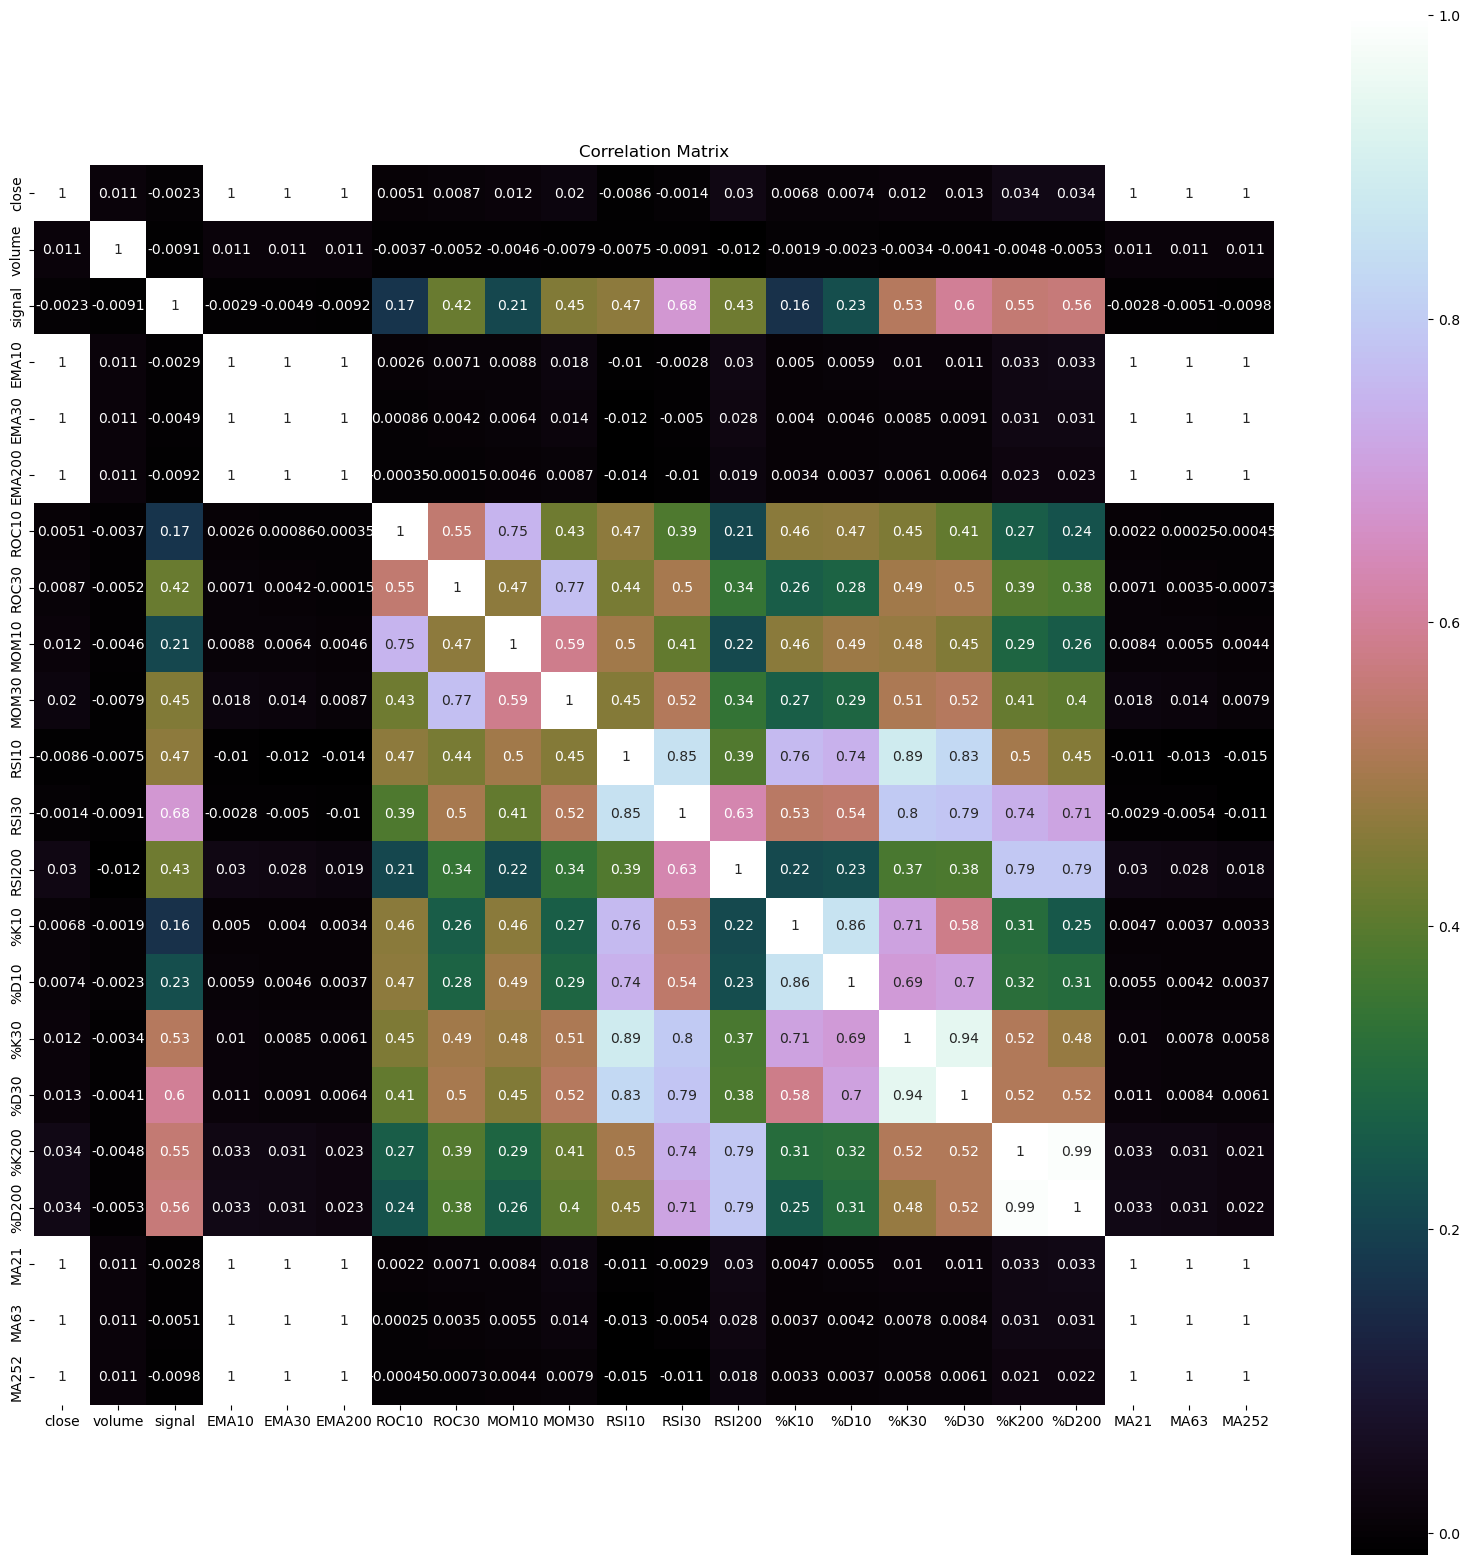

In [22]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

## Models and Algorithms

### Train-Test-Split

We split the dataset into 80% training set and 20% test set.

In [23]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### Evaluation Metrics and Test Options

In [27]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

### Compare Algorithms and Models

- In order to know which algorithm technic is the best for our strategy, we evaluate the following non linear different methods:

#### The Models

In [28]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier()))
# Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

#### K-folds cross validation

In [30]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.902200 (0.002196)
LDA: 0.913513 (0.001942)
KNN: 0.862725 (0.004572)
CART: 0.902363 (0.002592)
NB: 0.805300 (0.003953)
NN: 0.886825 (0.019926)
AB: 0.901387 (0.003893)
GBM: 0.914350 (0.003490)
RF: 0.936588 (0.002428)


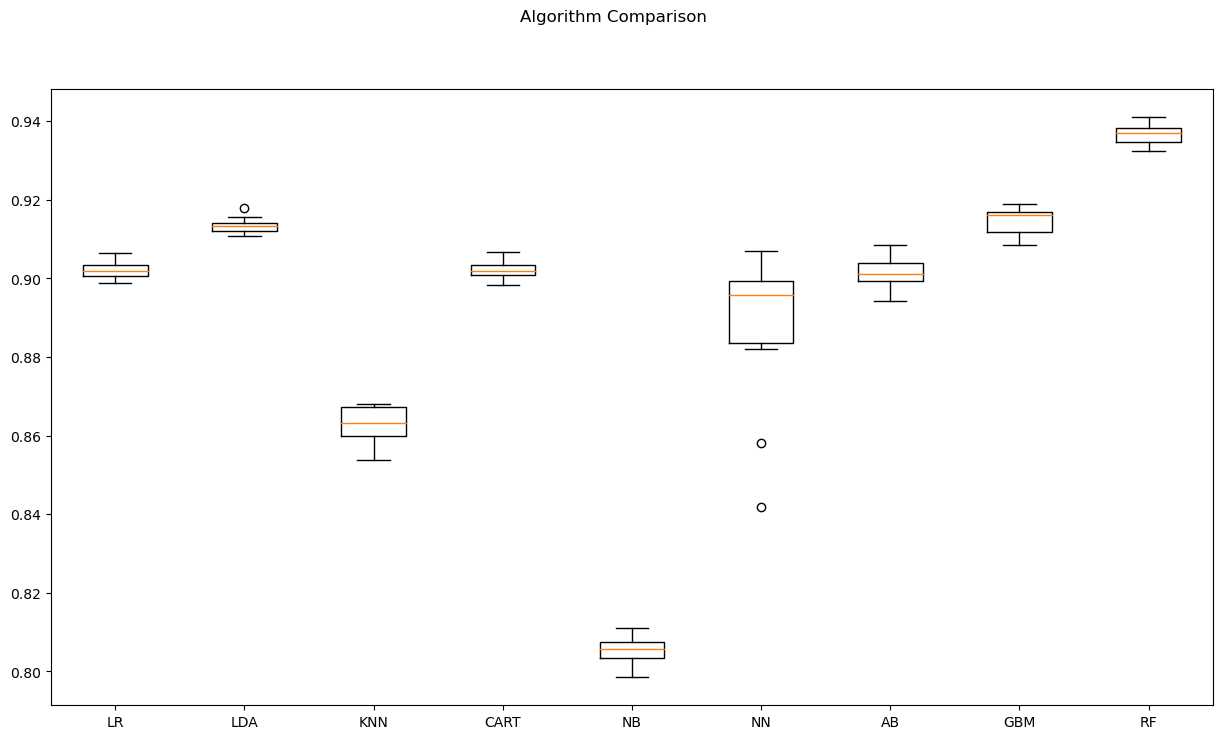

In [31]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Tuning the Model and the Grid Search

- Random forest is selected for the grid search as it is one of the best models out of them all.

In [33]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.914075 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#6 0.882337 (0.004265) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#7 0.882225 (0.004048) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.913287 (0.004392) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.914075 (0.003455) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.881050 (0.004437) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.882962 (0.003811) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.910763 (0.003815) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.912862 (0.003003) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


## Finalize the Model

Finalizing the model with best parameters found during tuning step.

###  Results on the Test Dataset

In [34]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [35]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9144
[[9463  864]
 [ 848 8825]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     10327
         1.0       0.91      0.91      0.91      9673

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

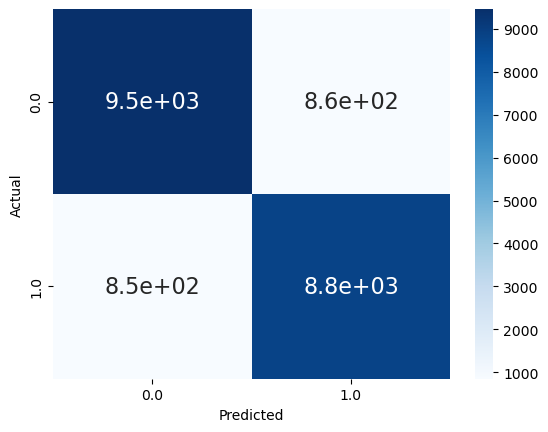

In [36]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

### Feature Importance of the model

- Let's look into the Feature Importance of the Model

Text(0.5, 0, 'Variable Importance')

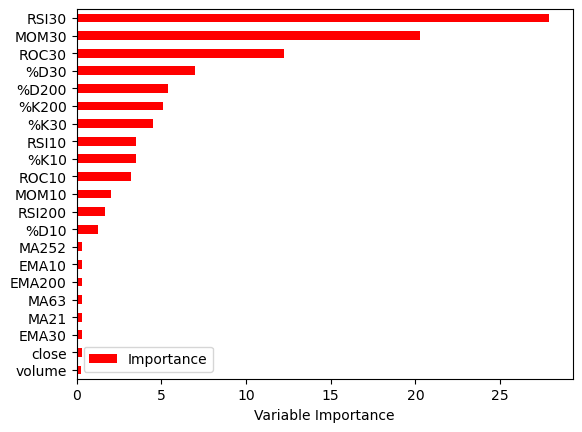

In [37]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

### The Backtesting Results

<AxesSubplot: >

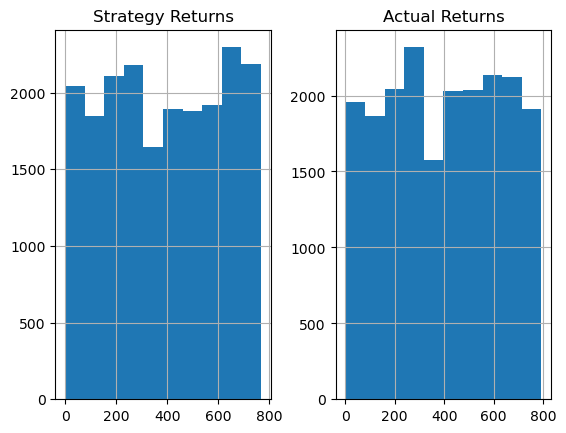

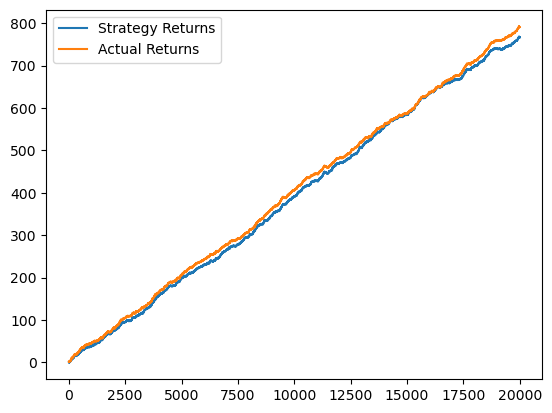

In [39]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()